In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import numpy as np
from datasets import *
from models import *

from torch.utils.tensorboard import SummaryWriter

In [2]:
root_dir = "/home/gc28692/Projects/data/nvgesture/nvGesture_v1"
batch_size = 128
tsfms = transforms.Compose([
        transforms.ToTensor()
        ]
    )
    
dataset = Gestures(root_dir,tsfms,train=True,subset=[0,1,2,3,4,5,6,7,9])#,10,11,12,13,15,17,18,21,22,23,24])
train_set, val_set = torch.utils.data.random_split(dataset, [int(len(dataset)*0.9), len(dataset)-int(len(dataset)*.9)])
test_set = Gestures(root_dir,tsfms,train=False,test=True,subset=[0,1,2,3,4,5,6,7,9])#,10,11,12,13,15,17,18,21,22,23,24])

# create the data loaders
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_set,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

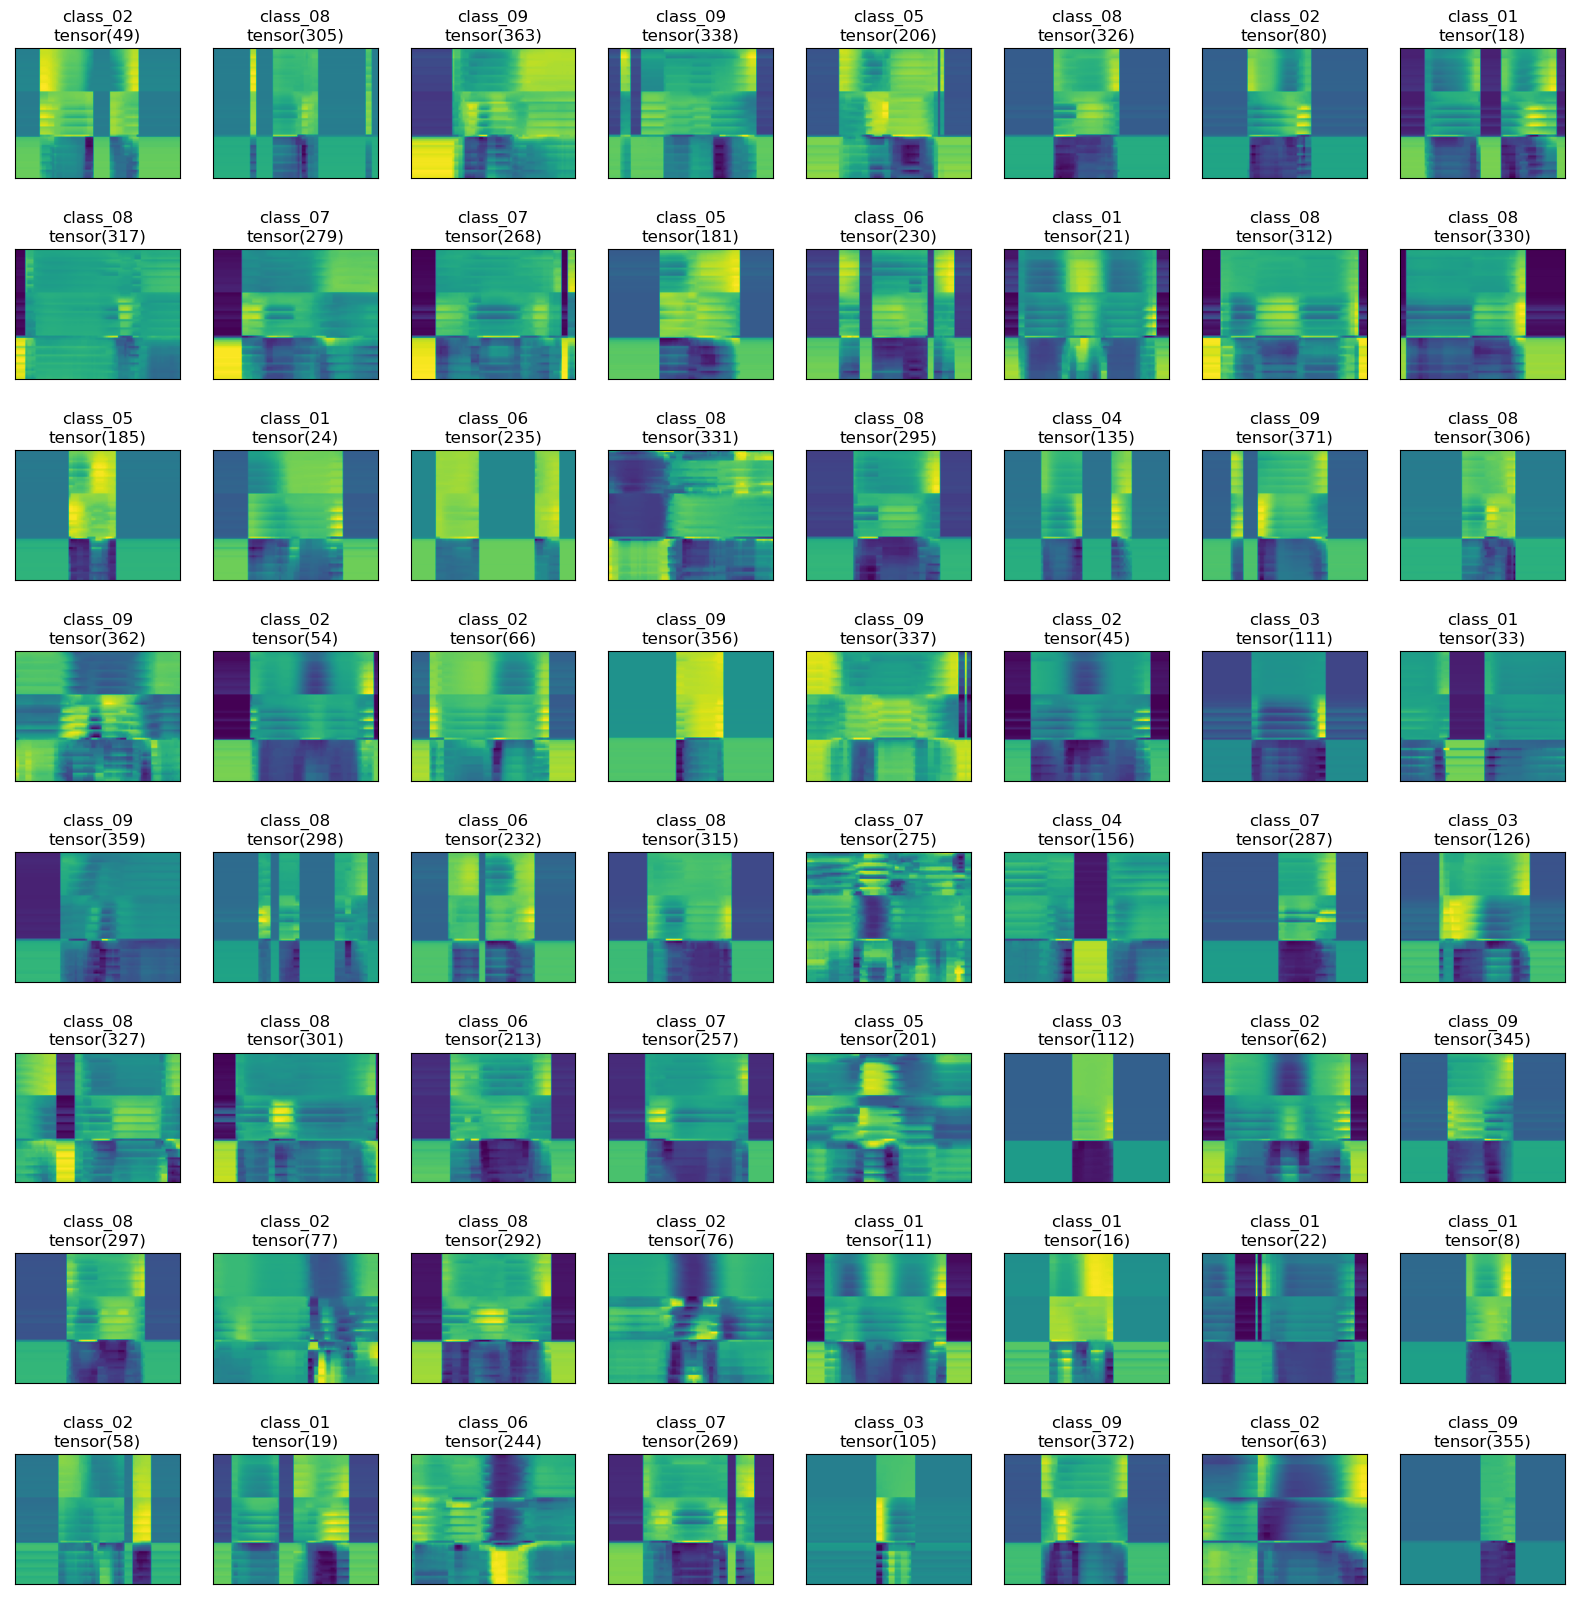

In [9]:
train_set.dataset.visualize_batch()

In [19]:
model = RNNModel(63,256,1,25,device='cuda').to('cuda')
model.load_state_dict(torch.load("models/Baseline.pth")['model_state_dict'])
model.eval()

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output[0].detach()
    return hook

model.rnn.register_forward_hook(get_activation('emb'))

In [20]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
# init tensorboard
writer = SummaryWriter()

with torch.no_grad():
    batch_imgs, batch_labels, _ = next(iter(test_loader))
    preds = model(batch_imgs.to('cuda'))
    embds = activation['emb'].squeeze(1).to('cpu')

    # get the labels
    batch_label_strings = []
    for idx,label in enumerate(batch_labels):
        batch_label_strings.append(str(label.item()))

    writer.add_embedding(embds,metadata=batch_label_strings)#,label_img=batch_imgs)